In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
#import utils
import models
from torchsummary import summary
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pdb
import albumentations as A
import DataAugmentations as Aug

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

inttoclasses = {i:classes for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
#Mean Train
print(Aug.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(Aug.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(Aug.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(Aug.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [5]:
training_iterator = iter(Aug.train_loader)

In [6]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

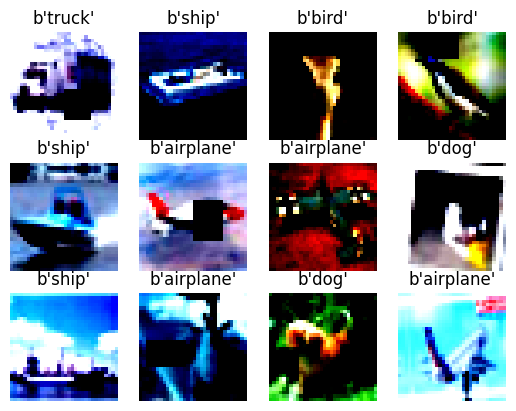

In [7]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [8]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [9]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #scheduler.step()
    # Update pbar-tqdm
    #lr= scheduler.get_last_lr()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(lr)
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    #pdb.set_trace()
    misclassified_images = data[(pred != target.view_as(pred)).view(-1)]
    misclassified_images_actual_label = target[(pred != target.view_as(pred)).view(-1)]
    misclassified_images_predicted_label = pred[(pred != target.view_as(pred)).view(-1)].squeeze(1)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss, misclassified_images, misclassified_images_actual_label, misclassified_images_predicted_label


In [10]:
device

'mps'

In [11]:
model = models.model3().to(device= device)

In [12]:


optimizer = optim.SGD(params = model.parameters(), lr = 0.1, momentum= 0.9)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
num_epochs = 50
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(Aug.train_loader), epochs=num_epochs, verbose= False)
# New Line


   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, Aug.train_loader, optimizer, scheduler)
    test_loss,misclassified_images, misclassified_images_actual_label, misclassified_images_predicted_label = test(model, device, Aug.test_loader)
    scheduler.step(test_loss)


Epoch 1


Loss=1.5940483808517456 Batch_id=390 Accuracy=38.47: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
/var/folders/bv/qb2wlknx6rqbx7ysszyd83h40000gn/T/ipykernel_75289/3536189859.py:61: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  misclassified_images = data[(pred != target.view_as(pred)).view(-1)]



Test set: Average loss: 1.4529, Accuracy: 4525/10000 (45.25%)

Epoch 2


Loss=1.2080050706863403 Batch_id=390 Accuracy=52.82: 100%|██████████| 391/391 [00:28<00:00, 13.68it/s]



Test set: Average loss: 1.3195, Accuracy: 5296/10000 (52.96%)

Epoch 3


Loss=0.9057930111885071 Batch_id=390 Accuracy=60.07: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]



Test set: Average loss: 1.0332, Accuracy: 6282/10000 (62.82%)

Epoch 4


Loss=1.1712020635604858 Batch_id=390 Accuracy=64.98: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]



Test set: Average loss: 0.9022, Accuracy: 6809/10000 (68.09%)

Epoch 5


Loss=0.9106027483940125 Batch_id=390 Accuracy=68.71: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]



Test set: Average loss: 0.8125, Accuracy: 7103/10000 (71.03%)

Epoch 6


Loss=0.6795706152915955 Batch_id=390 Accuracy=71.08: 100%|██████████| 391/391 [00:28<00:00, 13.70it/s]



Test set: Average loss: 0.7581, Accuracy: 7334/10000 (73.34%)

Epoch 7


Loss=1.0634468793869019 Batch_id=390 Accuracy=72.76: 100%|██████████| 391/391 [00:28<00:00, 13.68it/s]



Test set: Average loss: 0.7493, Accuracy: 7399/10000 (73.99%)

Epoch 8


Loss=0.535845935344696 Batch_id=390 Accuracy=74.35: 100%|██████████| 391/391 [00:28<00:00, 13.69it/s]  



Test set: Average loss: 0.7137, Accuracy: 7567/10000 (75.67%)

Epoch 9


Loss=0.626496434211731 Batch_id=390 Accuracy=75.42: 100%|██████████| 391/391 [00:28<00:00, 13.68it/s]  



Test set: Average loss: 0.6785, Accuracy: 7674/10000 (76.74%)

Epoch 10


Loss=0.679863452911377 Batch_id=390 Accuracy=76.08: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s]  



Test set: Average loss: 0.6612, Accuracy: 7697/10000 (76.97%)

Epoch 11


Loss=0.6508722901344299 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s] 



Test set: Average loss: 0.6480, Accuracy: 7846/10000 (78.46%)

Epoch 12


Loss=0.6641780734062195 Batch_id=390 Accuracy=77.80: 100%|██████████| 391/391 [00:28<00:00, 13.65it/s] 



Test set: Average loss: 0.6474, Accuracy: 7753/10000 (77.53%)

Epoch 13


Loss=0.7211963534355164 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:28<00:00, 13.66it/s] 



Test set: Average loss: 0.6058, Accuracy: 7880/10000 (78.80%)

Epoch 14


Loss=0.5003766417503357 Batch_id=390 Accuracy=78.66: 100%|██████████| 391/391 [00:28<00:00, 13.66it/s] 



Test set: Average loss: 0.5827, Accuracy: 7971/10000 (79.71%)

Epoch 15


Loss=0.752215564250946 Batch_id=390 Accuracy=79.32: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]  



Test set: Average loss: 0.6092, Accuracy: 7871/10000 (78.71%)

Epoch 16


Loss=0.6785133481025696 Batch_id=390 Accuracy=79.74: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 



Test set: Average loss: 0.5771, Accuracy: 7995/10000 (79.95%)

Epoch 17


Loss=0.6158355474472046 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s] 



Test set: Average loss: 0.5666, Accuracy: 8064/10000 (80.64%)

Epoch 18


Loss=0.540627658367157 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s]  



Test set: Average loss: 0.5656, Accuracy: 8069/10000 (80.69%)

Epoch 19


Loss=0.5023052096366882 Batch_id=390 Accuracy=80.71: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s] 



Test set: Average loss: 0.5651, Accuracy: 8046/10000 (80.46%)

Epoch 20


Loss=0.4104190766811371 Batch_id=390 Accuracy=81.15: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s] 



Test set: Average loss: 0.5959, Accuracy: 7984/10000 (79.84%)

Epoch 21


Loss=0.5850232839584351 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s] 



Test set: Average loss: 0.5414, Accuracy: 8129/10000 (81.29%)

Epoch 22


Loss=0.5130901336669922 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s] 



Test set: Average loss: 0.5716, Accuracy: 8033/10000 (80.33%)

Epoch 23


Loss=0.6202050447463989 Batch_id=390 Accuracy=81.90: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s] 



Test set: Average loss: 0.5209, Accuracy: 8248/10000 (82.48%)

Epoch 24


Loss=0.7182759642601013 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s] 



Test set: Average loss: 0.5383, Accuracy: 8177/10000 (81.77%)

Epoch 25


Loss=0.39292773604393005 Batch_id=390 Accuracy=82.43: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]



Test set: Average loss: 0.5236, Accuracy: 8190/10000 (81.90%)

Epoch 26


Loss=0.4613983631134033 Batch_id=390 Accuracy=82.71: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s] 



Test set: Average loss: 0.5109, Accuracy: 8258/10000 (82.58%)

Epoch 27


Loss=0.4133478105068207 Batch_id=390 Accuracy=82.78: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s] 



Test set: Average loss: 0.5088, Accuracy: 8263/10000 (82.63%)

Epoch 28


Loss=0.40897136926651 Batch_id=390 Accuracy=83.05: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]   



Test set: Average loss: 0.5166, Accuracy: 8262/10000 (82.62%)

Epoch 29


Loss=0.6384121775627136 Batch_id=390 Accuracy=82.97: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s] 



Test set: Average loss: 0.5114, Accuracy: 8255/10000 (82.55%)

Epoch 30


Loss=0.4641380310058594 Batch_id=390 Accuracy=83.27: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s] 



Test set: Average loss: 0.5136, Accuracy: 8236/10000 (82.36%)

Epoch 31


Loss=0.4242091774940491 Batch_id=390 Accuracy=85.16: 100%|██████████| 391/391 [09:15<00:00,  1.42s/it] 



Test set: Average loss: 0.4470, Accuracy: 8455/10000 (84.55%)

Epoch 32


Loss=0.5178557634353638 Batch_id=390 Accuracy=85.74: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s] 



Test set: Average loss: 0.4525, Accuracy: 8433/10000 (84.33%)

Epoch 33


Loss=0.5156354308128357 Batch_id=390 Accuracy=86.04: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s] 



Test set: Average loss: 0.4579, Accuracy: 8431/10000 (84.31%)

Epoch 34


Loss=0.4877736270427704 Batch_id=390 Accuracy=86.17: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s] 



Test set: Average loss: 0.4494, Accuracy: 8490/10000 (84.90%)

Epoch 35


Loss=0.41432610154151917 Batch_id=390 Accuracy=86.09: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]



Test set: Average loss: 0.4462, Accuracy: 8483/10000 (84.83%)

Epoch 36


Loss=0.40891122817993164 Batch_id=390 Accuracy=86.27: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]



Test set: Average loss: 0.4474, Accuracy: 8476/10000 (84.76%)

Epoch 37


Loss=0.5066550970077515 Batch_id=390 Accuracy=86.42: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s] 



Test set: Average loss: 0.4473, Accuracy: 8481/10000 (84.81%)

Epoch 38


Loss=0.7844406366348267 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s] 



Test set: Average loss: 0.4413, Accuracy: 8503/10000 (85.03%)

Epoch 39


Loss=0.4151453673839569 Batch_id=390 Accuracy=86.38: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s] 



Test set: Average loss: 0.4395, Accuracy: 8510/10000 (85.10%)

Epoch 40


Loss=0.34192728996276855 Batch_id=390 Accuracy=86.20: 100%|██████████| 391/391 [00:28<00:00, 13.65it/s]



Test set: Average loss: 0.4363, Accuracy: 8516/10000 (85.16%)

Epoch 41


Loss=0.2721352279186249 Batch_id=390 Accuracy=86.42: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s] 



Test set: Average loss: 0.4495, Accuracy: 8458/10000 (84.58%)

Epoch 42


Loss=0.4950673282146454 Batch_id=390 Accuracy=86.47: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s] 



Test set: Average loss: 0.4555, Accuracy: 8449/10000 (84.49%)

Epoch 43


Loss=0.43777838349342346 Batch_id=390 Accuracy=86.49: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]



Test set: Average loss: 0.4502, Accuracy: 8461/10000 (84.61%)

Epoch 44


Loss=0.3489873707294464 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s] 



Test set: Average loss: 0.4518, Accuracy: 8450/10000 (84.50%)

Epoch 45


Loss=0.3280939757823944 Batch_id=390 Accuracy=86.68: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s] 



Test set: Average loss: 0.4493, Accuracy: 8519/10000 (85.19%)

Epoch 46


Loss=0.5280857086181641 Batch_id=390 Accuracy=86.46: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s] 



Test set: Average loss: 0.4535, Accuracy: 8479/10000 (84.79%)

Epoch 47


Loss=0.33356767892837524 Batch_id=390 Accuracy=86.49: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s]



Test set: Average loss: 0.4518, Accuracy: 8470/10000 (84.70%)

Epoch 48


Loss=0.32616090774536133 Batch_id=390 Accuracy=86.40: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]



Test set: Average loss: 0.4484, Accuracy: 8466/10000 (84.66%)

Epoch 49


Loss=0.3017076551914215 Batch_id=390 Accuracy=86.57: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s] 



Test set: Average loss: 0.4560, Accuracy: 8440/10000 (84.40%)

Epoch 50


Loss=0.31124910712242126 Batch_id=390 Accuracy=86.62: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]



Test set: Average loss: 0.4453, Accuracy: 8485/10000 (84.85%)



In [13]:
misclassified_images = misclassified_images.cpu()
misclassified_images_actual_label = misclassified_images_actual_label.cpu()
misclassified_images_predicted_label = misclassified_images_predicted_label.cpu()
for i in range(len(misclassified_images)):
    plt.subplot(3,4,i+1)
    im = misclassified_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.title('Act: {}/ Pred: {}'.format(inttoclasses[misclassified_images_actual_label[i].item()], inttoclasses[misclassified_images_predicted_label[i].item()]))
    plt.axis('off')

In [14]:
len(misclassified_images)

0

In [15]:
model = models.model3()
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         Dropout2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]             288
           Conv2d-10           [-1, 32, 32, 32]           1,024
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        Dropout2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,